# Artificial Intelligence in Finance

## Dense Neural Networks

In [1]:
import os
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
pd.set_option('precision', 4)
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'

## The Data

In [2]:
url = 'http://hilpisch.com/aiif_eikon_id_eur_usd.csv'

In [3]:
symbol = 'EUR_USD'

In [4]:
raw = pd.read_csv(url, index_col=0, parse_dates=True)

In [5]:
raw.head()

,HIGH,LOW,OPEN,CLOSE
Date,,,,
2019-10-01 00:00:00,1.0899,1.0897,1.0897,1.0899
2019-10-01 00:01:00,1.0899,1.0896,1.0899,1.0898
2019-10-01 00:02:00,1.0898,1.0896,1.0898,1.0896
2019-10-01 00:03:00,1.0898,1.0896,1.0897,1.0898
2019-10-01 00:04:00,1.0898,1.0896,1.0897,1.0898


In [6]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96526 entries, 2019-10-01 00:00:00 to 2019-12-31 23:06:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HIGH    96526 non-null  float64
 1   LOW     96526 non-null  float64
 2   OPEN    96526 non-null  float64
 3   CLOSE   96526 non-null  float64
dtypes: float64(4)
memory usage: 3.7 MB


In [7]:
data = pd.DataFrame(raw['CLOSE'].loc[:])
data.columns = [symbol]

In [8]:
data = data.resample('1h', label='right').last().ffill()

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2208 entries, 2019-10-01 01:00:00 to 2020-01-01 00:00:00
Freq: H
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   EUR_USD  2208 non-null   float64
dtypes: float64(1)
memory usage: 34.5 KB


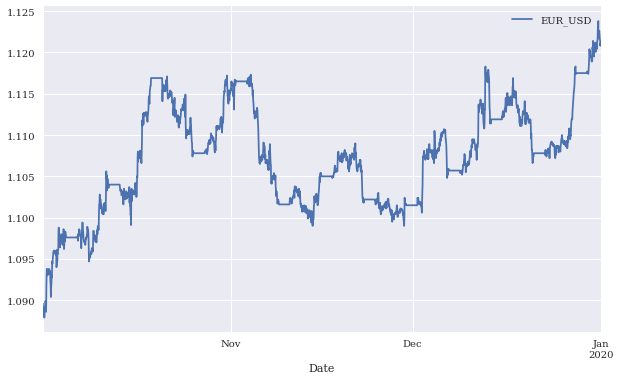

In [10]:
data.plot(figsize=(10, 6));

## Baseline Prediction

In [11]:
lags = 5

In [12]:
def add_lags(data, symbol, lags, window=20):
    cols = []
    df = data.copy()
    df.dropna(inplace=True)
    df['r'] = np.log(df / df.shift())
    df['sma'] = df[symbol].rolling(window).mean()
    df['min'] = df[symbol].rolling(window).min()
    df['max'] = df[symbol].rolling(window).max()
    df['mom'] = df['r'].rolling(window).mean()
    df['vol'] = df['r'].rolling(window).std()
    df.dropna(inplace=True)
    df['d'] = np.where(df['r'] > 0, 1, 0)
    features = [symbol, 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']
    for f in features:
        for lag in range(1, lags + 1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols

In [13]:
data, cols = add_lags(data, symbol, lags)

In [14]:
len(data)

2183

In [15]:
# data.iloc[:10, :14].round(4)

In [16]:
c = data['d'].value_counts()
c

0    1445
1     738
Name: d, dtype: int64

In [17]:
def cw(df):
    c0, c1 = np.bincount(df['d'])
    w0 = (1 / c0) * (len(df)) / 2
    w1 = (1 / c1) * (len(df)) / 2
    return {0: w0, 1: w1}

In [18]:
class_weight = cw(data)

In [19]:
class_weight

{0: 0.755363321799308, 1: 1.4789972899728998}

In [20]:
class_weight[0] * c[0]

1091.5

In [21]:
class_weight[1] * c[1]

1091.5

In [22]:
import random
import logging
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
tf.get_logger().setLevel(logging.ERROR)

In [23]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [24]:
optimizer = Adam(lr=0.001)

In [25]:
def create_model(hl=1, hu=128, optimizer=optimizer):
    model = Sequential()
    model.add(Dense(hu, input_dim=len(cols),
                    activation='relu'))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [26]:
set_seeds()
model = create_model(hl=1, hu=128)

In [27]:
%%time
model.fit(data[cols], data['d'], epochs=50,
          verbose=False, class_weight=cw(data))

Wall time: 7.39 s


In [28]:
model.evaluate(data[cols], data['d'])

69/69 [==============================] - 0s 2ms/step - loss: 0.5975 - accuracy: 0.5932


[0.5974940657615662, 0.5932203531265259]

In [29]:
data['p'] = np.where(model.predict(data[cols]) > 0.5, 1, 0)

In [30]:
data['p'].value_counts()

1    1468
0     715
Name: p, dtype: int64

In [31]:
split = int(len(data) * 0.8)

In [32]:
train = data.iloc[:split].copy()

In [33]:
test = data.iloc[split:].copy()

In [34]:
set_seeds()
model = create_model(hl=1, hu=128)

In [35]:
%%time 
h = model.fit(train[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

Wall time: 16.2 s


In [36]:
model.evaluate(train[cols], train['d'])

55/55 [==============================] - 0s 1ms/step - loss: 0.6096 - accuracy: 0.5934


[0.6096417903900146, 0.5933562517166138]

In [37]:
model.evaluate(test[cols], test['d'])

14/14 [==============================] - 0s 1ms/step - loss: 0.5931 - accuracy: 0.6133


[0.5931044816970825, 0.6132723093032837]

In [38]:
test['p'] = np.where(model.predict(test[cols]) > 0.5, 1, 0)

In [39]:
test['p'].value_counts()

1    284
0    153
Name: p, dtype: int64

In [40]:
res = pd.DataFrame(h.history)

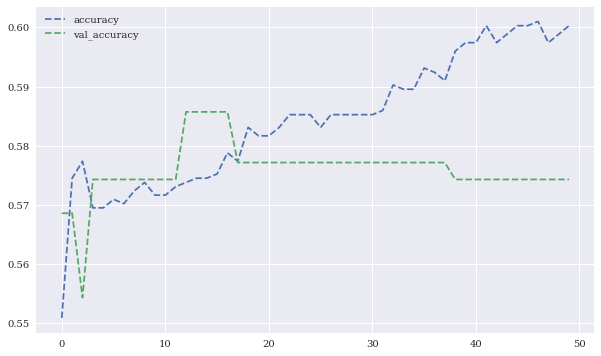

In [41]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

## Normalization

In [42]:
mu, std = train.mean(), train.std()

In [43]:
train_ = (train - mu) / std

In [44]:
# train_.std().round(3)

In [45]:
set_seeds()
model = create_model(hl=2, hu=128)

In [46]:
%%time 
h = model.fit(train_[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

Wall time: 13.4 s


In [47]:
model.evaluate(train_[cols], train['d'])

55/55 [==============================] - 0s 1ms/step - loss: 0.5126 - accuracy: 0.8654


[0.5126276612281799, 0.8654066324234009]

In [48]:
test_ = (test - mu) / std

In [49]:
model.evaluate(test_[cols], test['d'])

14/14 [==============================] - 0s 2ms/step - loss: 1.1863 - accuracy: 0.6819


[1.186348557472229, 0.681922197341919]

In [50]:
test['p'] = np.where(model.predict(test_[cols]) > 0.5, 1, 0)

In [51]:
test['p'].value_counts()

0    329
1    108
Name: p, dtype: int64

In [52]:
res = pd.DataFrame(h.history)

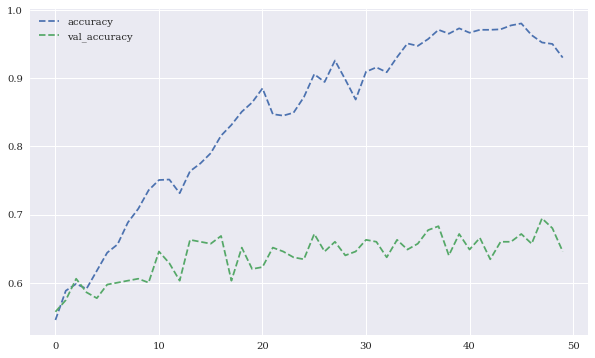

In [53]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

## Dropout 

In [54]:
from keras.layers import Dropout

In [55]:
def create_model(hl=1, hu=128, dropout=True, rate=0.3,
                 optimizer=optimizer):
    model = Sequential()
    model.add(Dense(hu, input_dim=len(cols),
                    activation='relu'))
    if dropout:
        model.add(Dropout(rate, seed=100))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu'))
        if dropout:
            model.add(Dropout(rate, seed=100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                 metrics=['accuracy'])
    return model

In [56]:
set_seeds()
model = create_model(hl=1, hu=128, rate=0.3)

In [57]:
%%time 
h = model.fit(train_[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.15, shuffle=False,
          class_weight=cw(train))

Wall time: 14.4 s


In [58]:
model.evaluate(train_[cols], train['d'])

55/55 [==============================] - 0s 2ms/step - loss: 0.4428 - accuracy: 0.7772


[0.44277796149253845, 0.7772050499916077]

In [59]:
model.evaluate(test_[cols], test['d'])

14/14 [==============================] - 0s 1ms/step - loss: 0.5767 - accuracy: 0.6476


[0.5766616463661194, 0.6475972533226013]

In [60]:
res = pd.DataFrame(h.history)

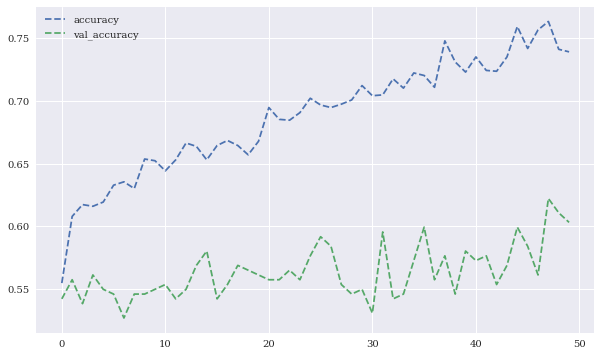

In [61]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

## Regularization 

In [62]:
from keras.regularizers import l1, l2

In [63]:
def create_model(hl=1, hu=128, dropout=False, rate=0.3, 
                 regularize=False, reg=l1(0.0005),
                 optimizer=optimizer, input_dim=len(cols)):
    if not regularize:
        reg = None
    model = Sequential()
    model.add(Dense(hu, input_dim=input_dim,
                    activity_regularizer=reg,
                    activation='relu'))
    if dropout:
        model.add(Dropout(rate, seed=100))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu',
                        activity_regularizer=reg))
        if dropout:
            model.add(Dropout(rate, seed=100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                 metrics=['accuracy'])
    return model

In [64]:
set_seeds()
model = create_model(hl=1, hu=128, regularize=True)

In [65]:
%%time 
h = model.fit(train_[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

Wall time: 11.7 s


In [66]:
model.evaluate(train_[cols], train['d'])

55/55 [==============================] - 0s 1ms/step - loss: 0.3641 - accuracy: 0.8940


[0.36406561732292175, 0.894043505191803]

In [67]:
model.evaluate(test_[cols], test['d'])

14/14 [==============================] - 0s 2ms/step - loss: 0.9213 - accuracy: 0.6705


[0.9212585091590881, 0.6704805493354797]

In [68]:
res = pd.DataFrame(h.history)

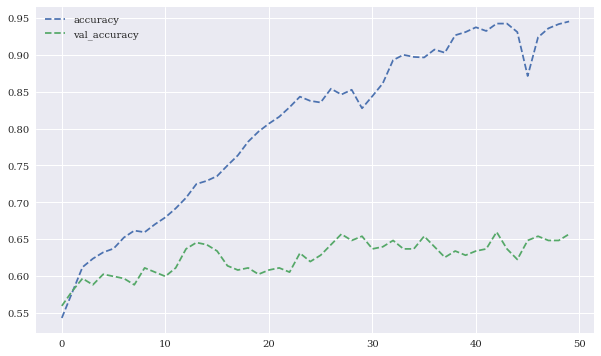

In [69]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

In [70]:
set_seeds()
h = model = create_model(hl=2, hu=128,
                     dropout=True, rate=0.3,
                     regularize=True, reg=l2(0.001),
                    )

In [71]:
%%time 
h = model.fit(train_[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

Wall time: 15.4 s


In [72]:
model.evaluate(train_[cols], train['d'])

55/55 [==============================] - 0s 2ms/step - loss: 0.4535 - accuracy: 0.7835


[0.45345136523246765, 0.7835051417350769]

In [73]:
model.evaluate(test_[cols], test['d'])

14/14 [==============================] - 0s 2ms/step - loss: 0.6433 - accuracy: 0.6751


[0.6433439254760742, 0.6750572323799133]

In [74]:
res = pd.DataFrame(h.history)

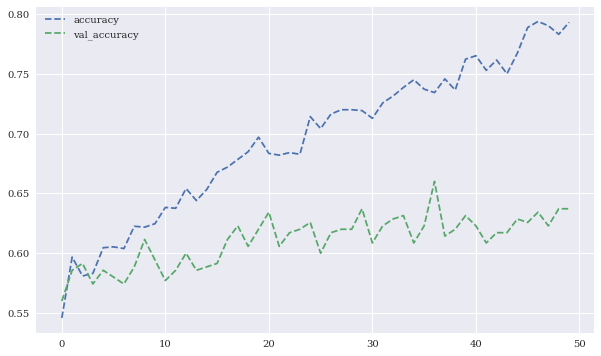

In [75]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

In [76]:
res.mean()['accuracy'] - res.mean()['val_accuracy']

0.08448604345321653

## Bagging

In [77]:
from sklearn.ensemble import BaggingClassifier
from keras.wrappers.scikit_learn import KerasClassifier

In [78]:
len(cols)

40

In [79]:
max_features = 0.75

In [80]:
set_seeds()
base_estimator = KerasClassifier(build_fn=create_model,
                        verbose=False, epochs=20, hl=1, hu=128,
                        dropout=True, regularize=False,
                        input_dim=int(len(cols) * max_features))

In [81]:
model_bag = BaggingClassifier(base_estimator=base_estimator,
                          n_estimators=15,
                          max_samples=0.75,
                          max_features=max_features,
                          bootstrap=True,
                          bootstrap_features=True,
                          n_jobs=1,
                          random_state=100,
                         )

In [82]:
%time model_bag.fit(train_[cols], train['d'])

Wall time: 40.5 s


BaggingClassifier(base_estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001707FD52220>,
                  bootstrap_features=True, max_features=0.75, max_samples=0.75,
                  n_estimators=15, n_jobs=1, random_state=100)

In [83]:
model_bag.score(train_[cols], train['d'])

C:\Users\Public\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


0.7623138602520045

In [84]:
model_bag.score(test_[cols], test['d'])

C:\Users\Public\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


0.665903890160183

In [85]:
test['p'] = model_bag.predict(test_[cols])

C:\Users\Public\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [86]:
test['p'].value_counts()

0    382
1     55
Name: p, dtype: int64

## Optimizers

In [87]:
import time

In [88]:
optimizers = ['sgd', 'rmsprop', 'adagrad', 'adadelta',
              'adam', 'adamax', 'nadam']

In [ ]:
%%time
for optimizer in optimizers:
    set_seeds()
    model = create_model(hl=1, hu=128,
                     dropout=True, rate=0.3,
                     regularize=False, reg=l2(0.001),
                     optimizer=optimizer
                    )
    t0 = time.time()
    model.fit(train_[cols], train['d'],
              epochs=50, verbose=False,
              validation_split=0.2, shuffle=False,
              class_weight=cw(train))
    t1 = time.time()
    t = t1 - t0
    acc_tr = model.evaluate(train_[cols], train['d'], verbose=False)[1]
    acc_te = model.evaluate(test_[cols], test['d'], verbose=False)[1]
    out = f'{optimizer:10s} | time[s]: {t:.4f} | in-sample={acc_tr:.4f}'
    out += f' | out-of-sample={acc_te:.4f}'
    print(out)

sgd        | time[s]: 13.3078 | in-sample=0.6077 | out-of-sample=0.6499


In [ ]:
test['p'] = np.where(model.predict(test_[cols]) > 0.5, 1, 0)

In [ ]:
test['p'].value_counts()

In [ ]:
accuracy_score(test['p'], test['d'])